$$
\underbrace{
\begin{pmatrix}
x_n\\
v_{x,n}\\
y_n\\
v_{y,n}\\
\end{pmatrix}}_{X_n}=
\underbrace{
\begin{pmatrix}
1&\Delta t&0&0\\
0&1&0&0\\
0&0&1&\Delta t\\
0&0&0&1\\
\end{pmatrix}}_{A}*
\underbrace{
\begin{pmatrix}
x_{n-1}\\
v_{x,n-1}\\
y_{n-1}\\
v_{y,n-1}\\
\end{pmatrix}}_{X_{n-1}}+
\underbrace{
\begin{pmatrix}
\Delta t^2/2&0&0&0\\
0&\Delta t&0&0\\
0&0&\Delta t^2/2&0\\
0&0&0&\Delta t\\
\end{pmatrix}}_{B}*
\underbrace{
\begin{pmatrix}
a_{x,n}\\
a_{x,n}\\
a_{y,n}\\
a_{y,n}\\
\end{pmatrix}}_{u_{n}}
$$

$$
P=
\begin{pmatrix}
0.5&0&0&0\\
0&0.5&0&0\\
0&0&0.5&0\\
0&0&0&0.5\\
\end{pmatrix}
$$

$$
Q=
\begin{pmatrix}
0.5&0&0&0\\
0&0.5&0&0\\
0&0&0.5&0\\
0&0&0&0.5\\
\end{pmatrix}
R=
\begin{pmatrix}
0.5&0&0&0\\
0&0.5&0&0\\
0&0&0.5&0\\
0&0&0&0.5\\
\end{pmatrix}
H=
\begin{pmatrix}
1&0&0&0\\
0&1&0&0\\
0&0&1&0\\
0&0&0&1\\
\end{pmatrix}
$$

In [0]:
import numpy as np
import pandas as pd
import csv
import plotly.express as px
import plotly.graph_objects as go
import pylab
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
mpl.rcParams['figure.dpi']= 150

In [64]:
!gdown https://drive.google.com/uc?id=1K4AbsHuATCMgFfzKyxMBJOgtt9rcFNFj
input_data = pd.read_csv('input.csv')

time = np.array(input_data['time'], dtype='float')
lat = np.array(input_data['lat'], dtype='float')
lng = np.array(input_data['lng'], dtype='float')
acc_lat = np.array(input_data['acc_lat'], dtype='float')
acc_lng = np.array(input_data['acc_lng'], dtype='float')
vel_lat = np.array(input_data['vel_lat'], dtype='float')
vel_lng = np.array(input_data['vel_lng'], dtype='float')

time = np.dot(time, 0.001)

Downloading...
From: https://drive.google.com/uc?id=1K4AbsHuATCMgFfzKyxMBJOgtt9rcFNFj
To: /content/input.csv
100% 30.4k/30.4k [00:00<00:00, 26.5MB/s]


In [0]:
lat_filtered = [lat[0]]
vel_lat_filtered = [vel_lat[0]]
lng_filtered = [lng[0]]
vel_lng_filtered = [vel_lng[0]]

H = np.eye(4)
A = np.eye(4)
B = np.eye(4)
Q = np.matrix([[0.5,0,0,0],[0,0.5,0,0],[0,0,0.5,0],[0,0,0,0.5]])
R = np.matrix([[0.5,0,0,0],[0,0.5,0,0],[0,0,0.5,0],[0,0,0,0.5]])

P_prev = np.matrix([[0.5,0,0,0],[0,0.5,0,0],[0,0,0.5,0],[0,0,0,0.5]])
x_prev = np.transpose(np.matrix([lat[0], vel_lat[0], lng[0], vel_lng[0]]))

In [0]:
itirations = len(time)

for i in range(1, itirations):
  delta_time = time[i]-time[i-1]
  A[0,1] = delta_time
  A[2,3] = delta_time
  B[0,0] = delta_time**2/2
  B[1,1] = delta_time
  B[2,2] = delta_time**2/2
  B[3,3] = delta_time

  u_prev = np.transpose(np.matrix([acc_lat[i], acc_lat[i], acc_lng[i], acc_lng[i]]))
  x_predicted = A*x_prev + B*u_prev
  P_predicted = A*P_prev*np.transpose(A) + Q

  z = np.transpose(np.matrix([lat[i], vel_lat[i], lng[i], vel_lng[i]]))
  y_hat = z - H*x_predicted
  S = H*P_predicted*np.transpose(H) + R
  K = P_predicted*np.transpose(H)*np.linalg.inv(S)
  
  x_prev = x_predicted + K*y_hat
  P_prev = (np.eye(4) - K*H)*P_predicted

  lat_filtered.append(x_prev[0,0])
  vel_lat_filtered.append(x_prev[1,0])
  lng_filtered.append(x_prev[2,0])
  vel_lng_filtered.append(x_prev[3,0])

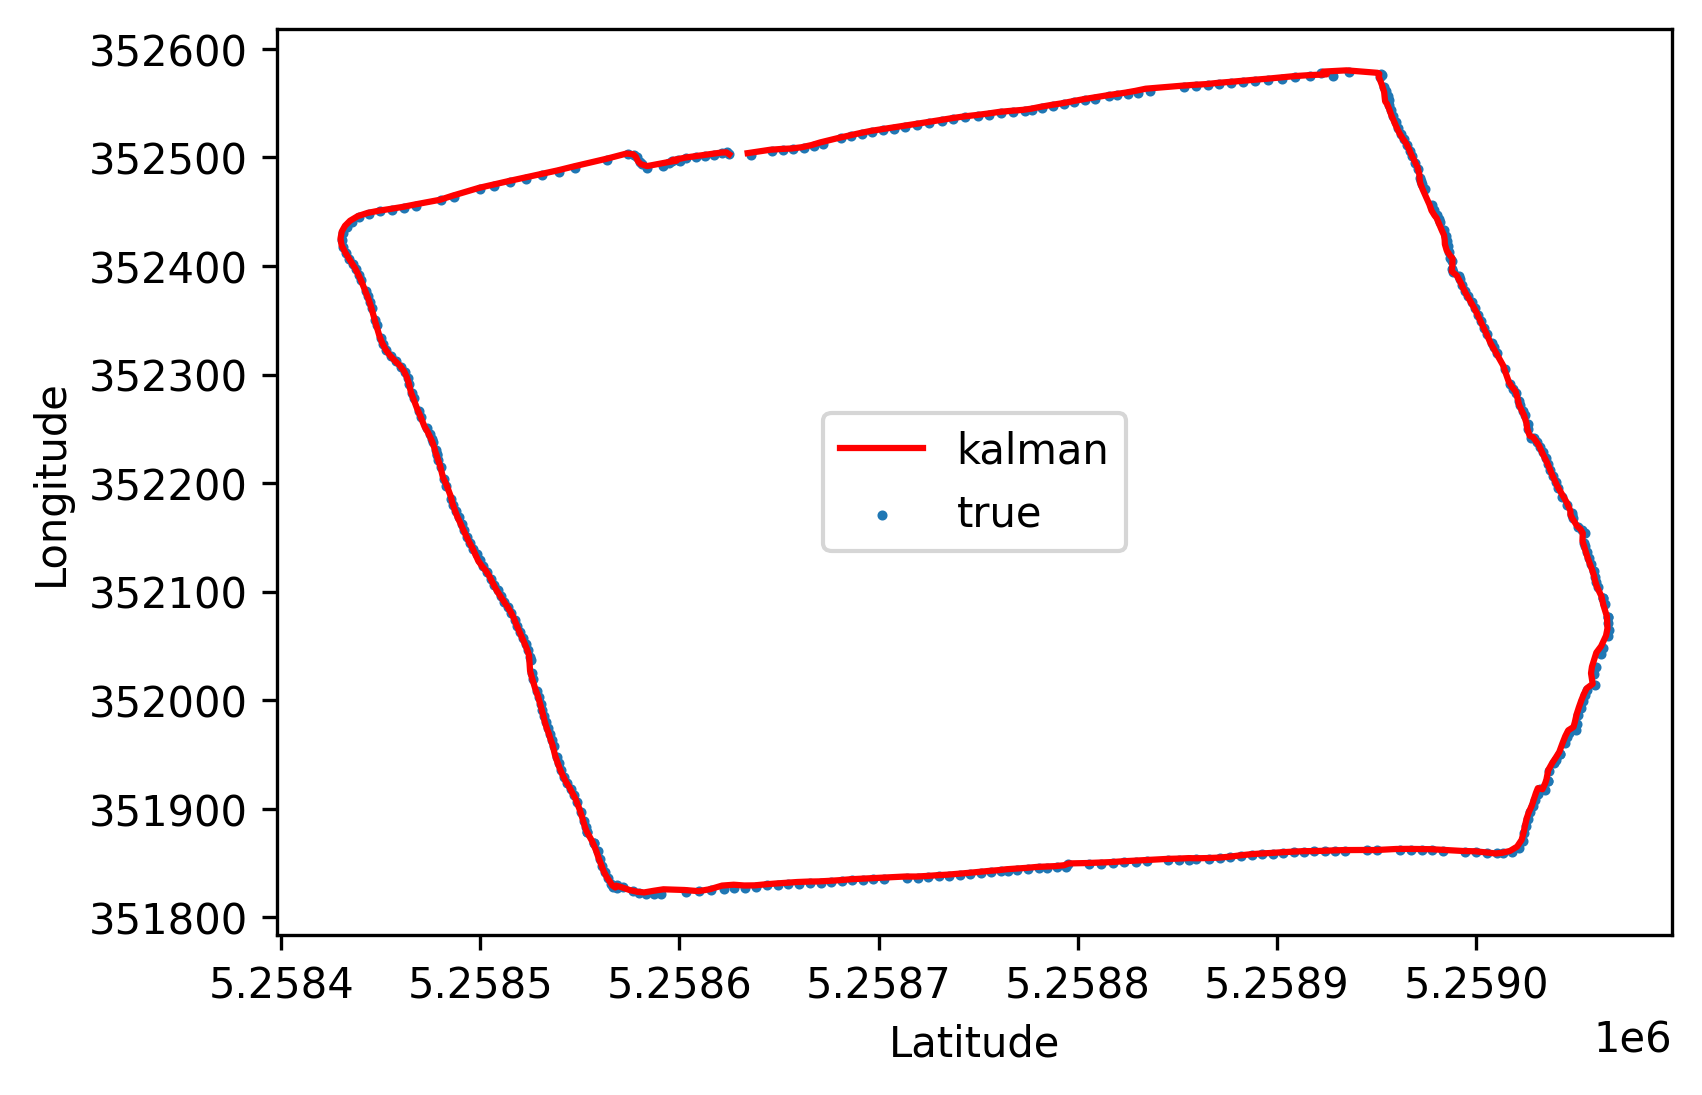

In [67]:
plt.plot(lat_filtered, lng_filtered, 'r')
plt.scatter(lat, lng, s=2)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend(('kalman','true'))
plt.savefig('path.png')
plt.show()

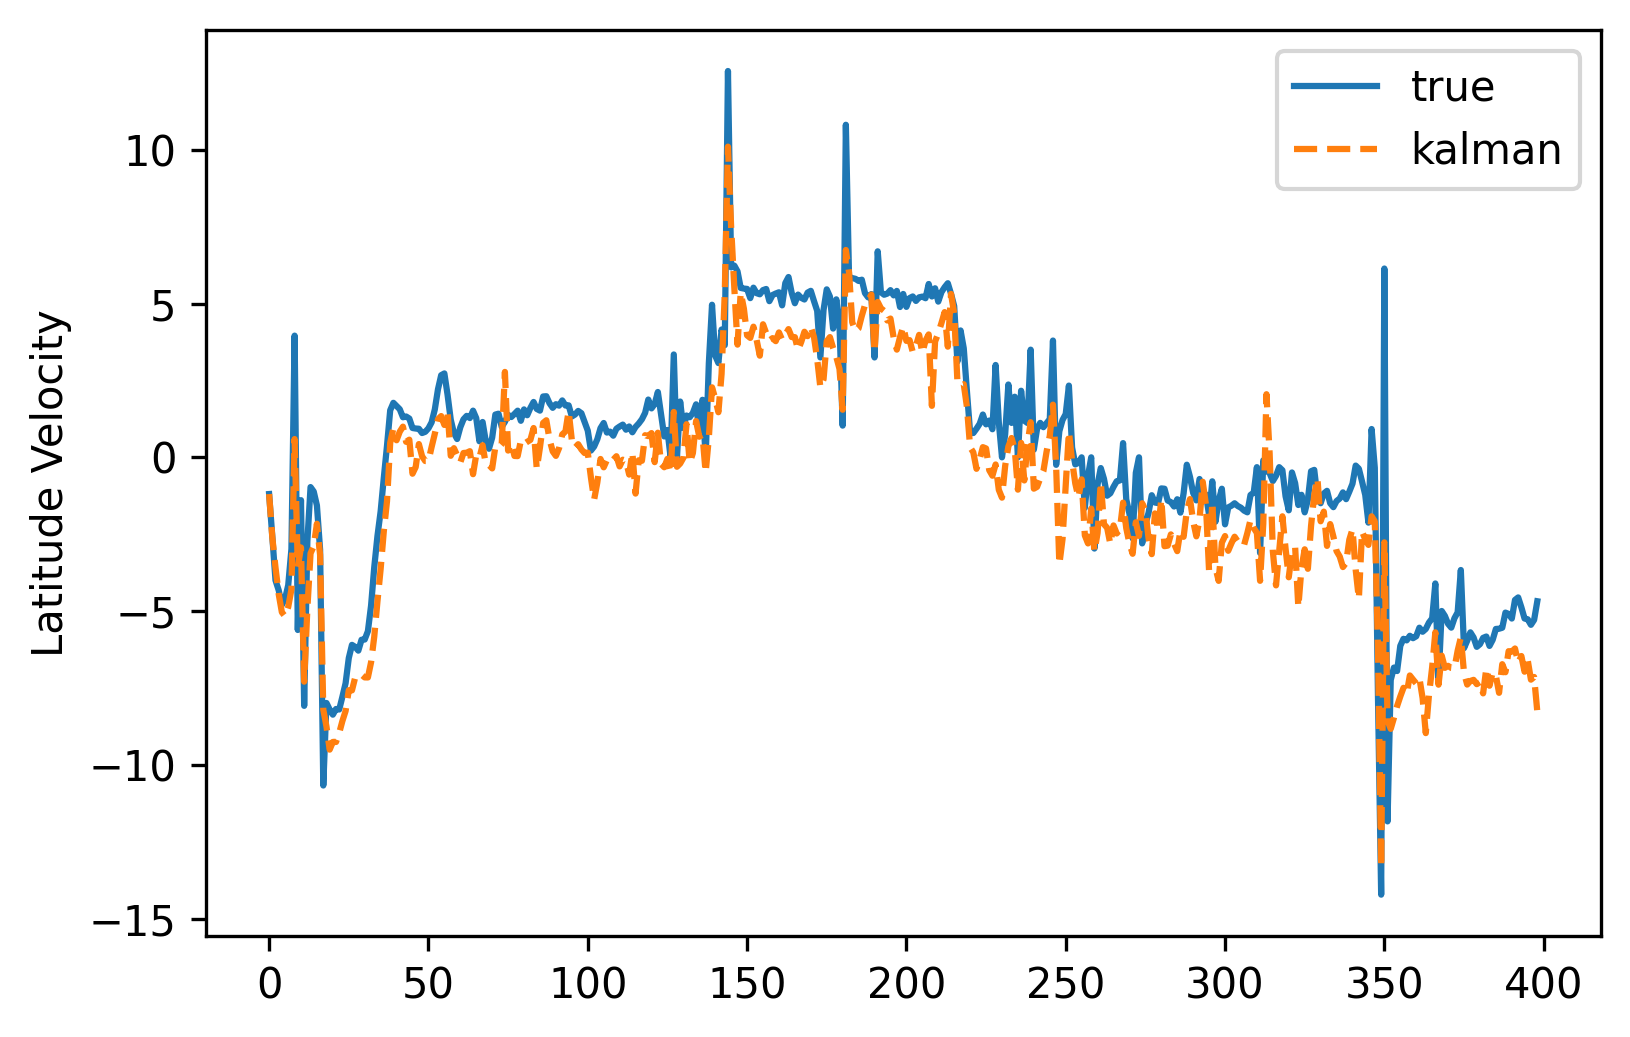

In [68]:
plt.plot(vel_lat, '-',vel_lat_filtered,'--')
plt.ylabel('Latitude Velocity')
plt.legend(('true','kalman'))
plt.savefig('lat-vel.png')
plt.show()

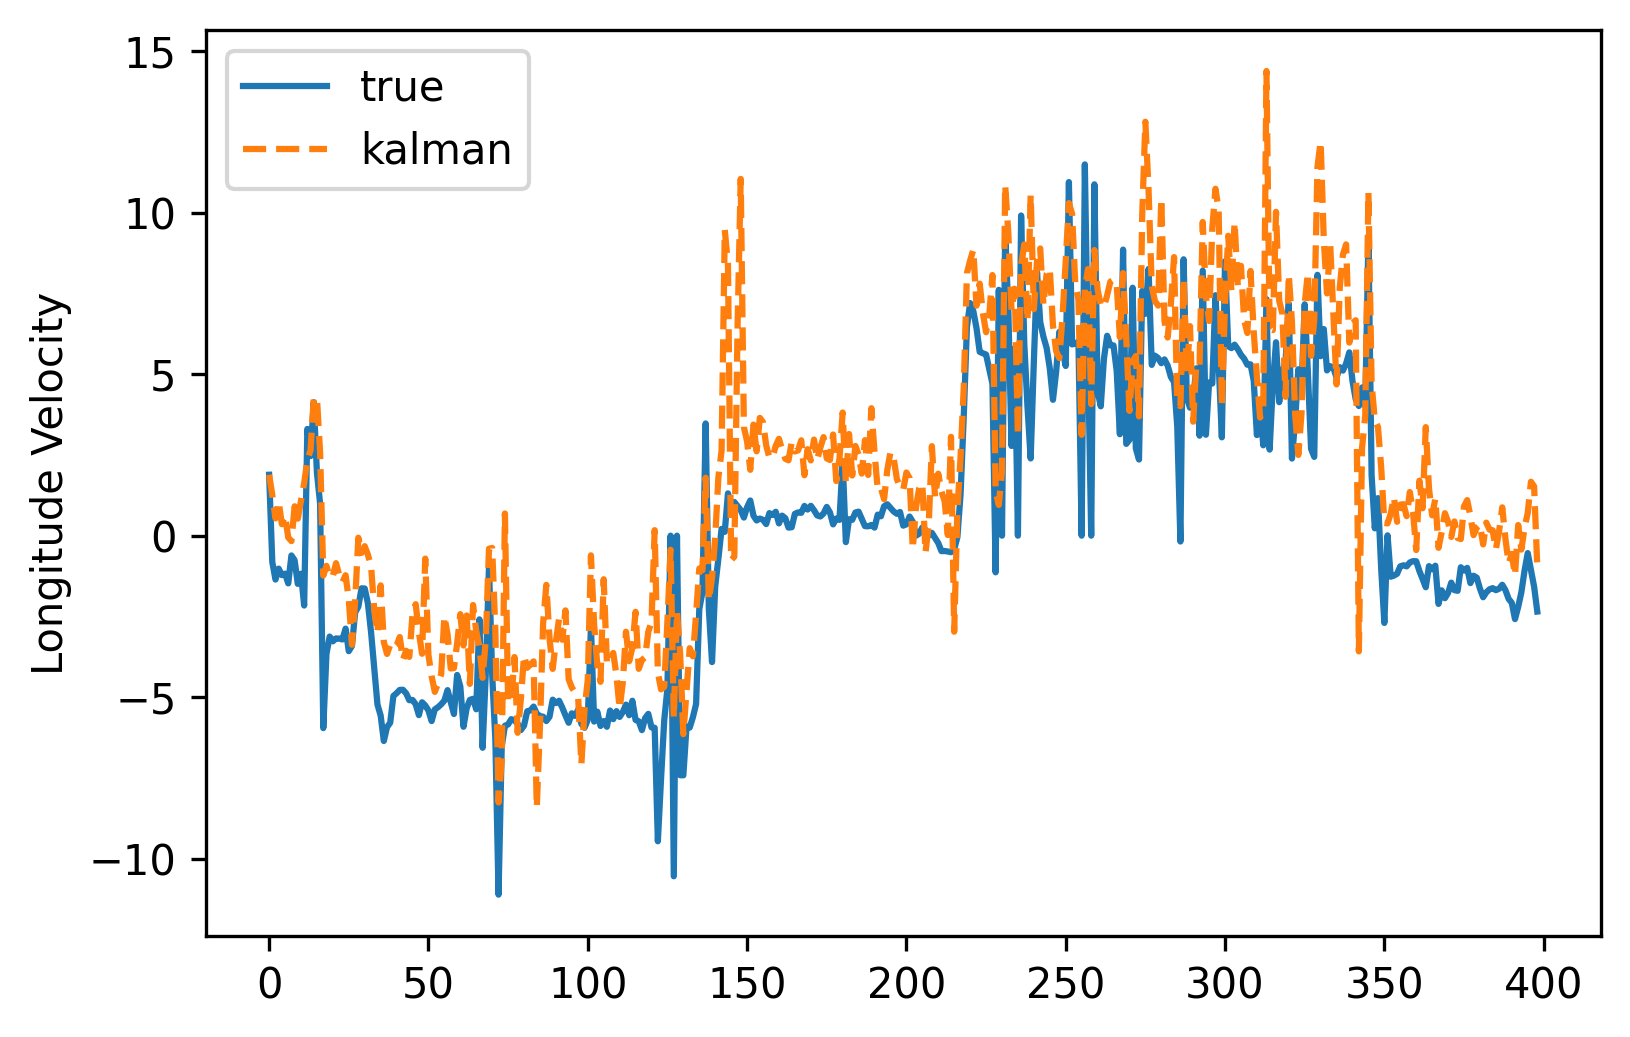

In [69]:
plt.plot(vel_lng, '-',vel_lng_filtered,'--')
plt.ylabel('Longitude Velocity')
plt.legend(('true','kalman'))
plt.savefig('lng-vel.png')
plt.show()

In [0]:
with open('output.csv', 'w',) as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['lat_filtered_utm', 'lng_filtered_utm'])
    for i in range(len(lat_filtered)):
        writer.writerow([lat_filtered[i], lng_filtered[i]])